In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

# Data Preprocessing

In [2]:
# fetch the data
bmw = yf.Ticker("BMW.DE")
bmw

yfinance.Ticker object <BMW.DE>

In [3]:
#Get historical data
bmw_data = bmw.history(start ="2015-01-01", end=date.today(), interval="1d")

bmw_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-07,94.769997,95.889999,94.169998,95.889999,1111346,0.0,0
2021-06-08,95.870003,96.000000,94.220001,95.519997,1282271,0.0,0
2021-06-09,95.400002,96.389999,93.959999,94.599998,1109590,0.0,0
2021-06-10,94.099998,94.269997,92.839996,92.849998,1300015,0.0,0
2021-06-11,93.169998,94.839996,92.709999,94.739998,941041,0.0,0


### Data Visualization

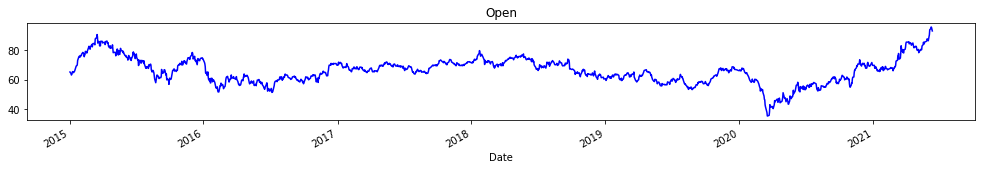

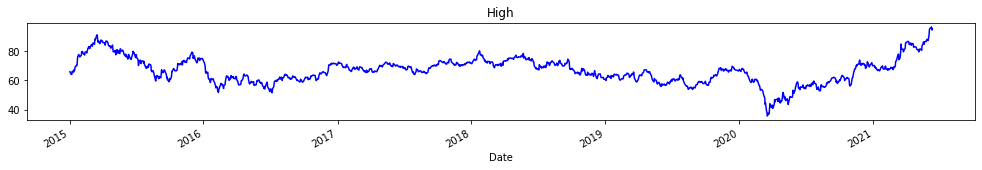

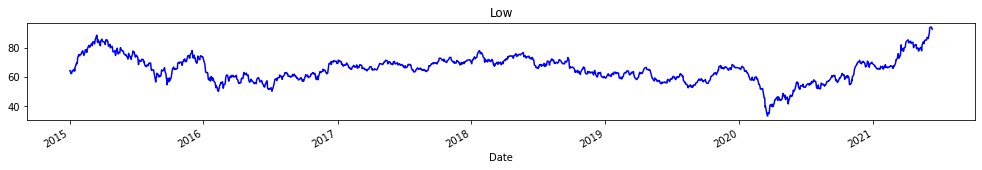

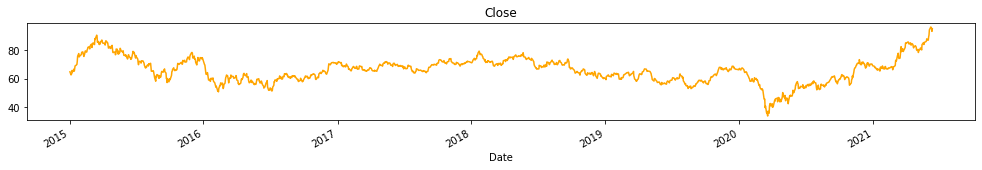

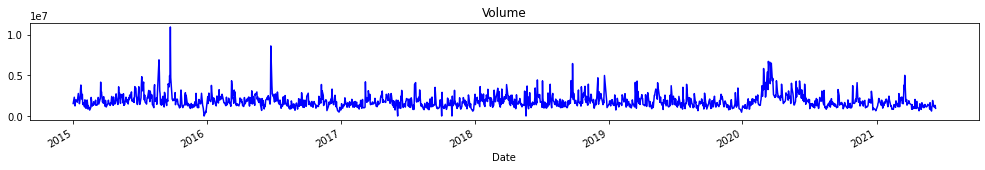

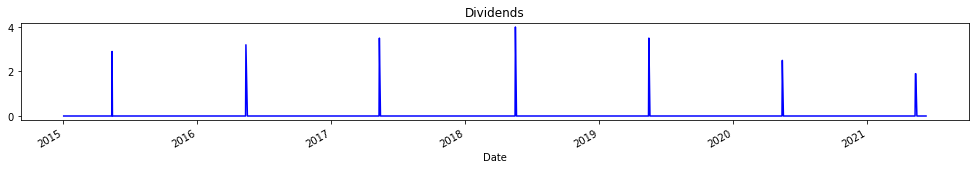

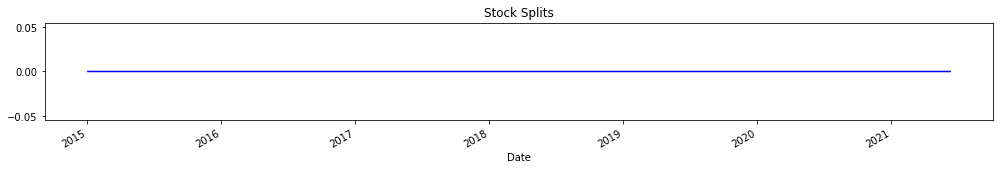

In [4]:
%matplotlib inline

for col in bmw_data.columns:
    color="orange" if col == "Close" else "blue"
    bmw_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
bmw_data = bmw_data.reset_index()
bmw_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02,65.186679,65.915061,64.289073,64.752594,1532820,0.0,0
1,2015-01-05,64.141922,64.178711,62.206925,62.596867,2308143,0.0,0
2,2015-01-06,63.126587,64.097765,62.206911,63.148659,1841589,0.0,0
3,2015-01-07,63.568046,64.046279,62.736655,63.487114,1239393,0.0,0
4,2015-01-08,64.392068,66.121064,63.921194,65.767906,1837539,0.0,0


In [6]:
#check if date is in datetime format
bmw_data.Date.dtype

dtype('<M8[ns]')

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [8]:
#Extracting the date and close price columns
bmw_df = bmw_data[["Date", "Close"]]
bmw_df.head()

,Date,Close
0,2015-01-02,64.752594
1,2015-01-05,62.596867
2,2015-01-06,63.148659
3,2015-01-07,63.487114
4,2015-01-08,65.767906


In [9]:
#rename the columns
bmw_df = bmw_df.rename(columns={'Date': 'ds', 'Close': 'y'})
bmw_df.head()

,ds,y
0,2015-01-02,64.752594
1,2015-01-05,62.596867
2,2015-01-06,63.148659
3,2015-01-07,63.487114
4,2015-01-08,65.767906


### Splitting the Data

In [11]:
index = int(0.8 * bmw_df.shape[0])
train_df = bmw_df[:index]
test_df = bmw_df[index:]

In [12]:
print(train_df.shape)
print(test_df.shape)

(1306, 2)
(327, 2)


### Hyperparameter Tuning

In [13]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [14]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [15]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [16]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1337,2022-09-30,60.547903,-294.458247,398.815860
1338,2022-10-31,64.710296,-306.396662,415.434166
1339,2022-11-30,67.242663,-319.772388,434.757892
1340,2022-12-31,67.245145,-336.582660,450.426433
1341,2023-01-31,64.721255,-353.047755,467.403317


## Plotting the Forecast

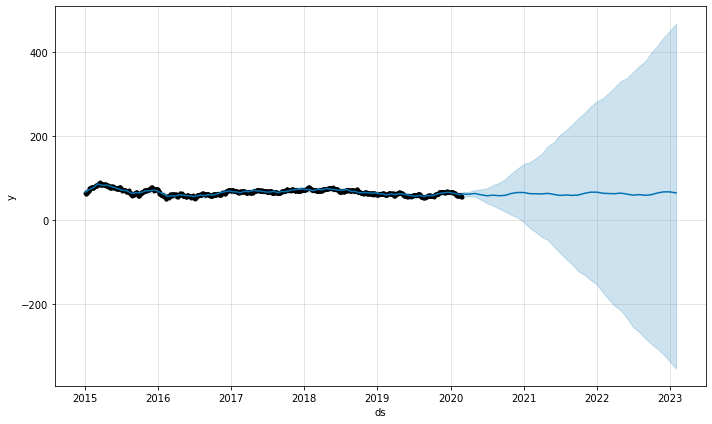

In [17]:
ax = model.plot(forecast);

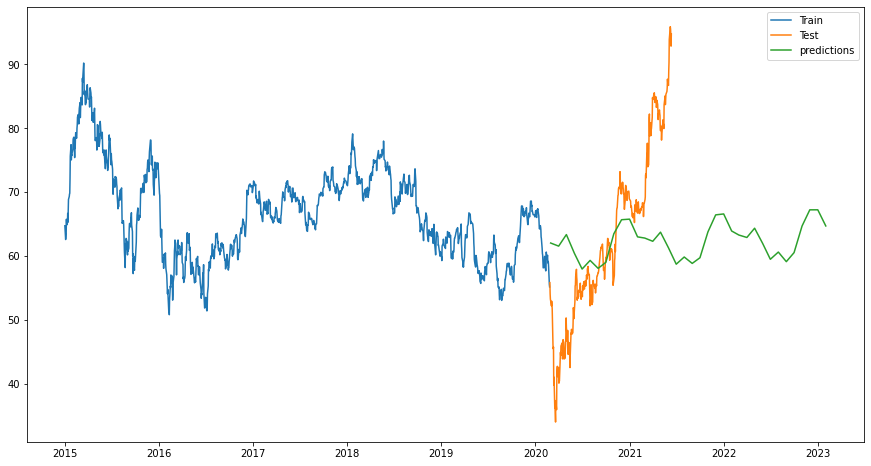

In [18]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

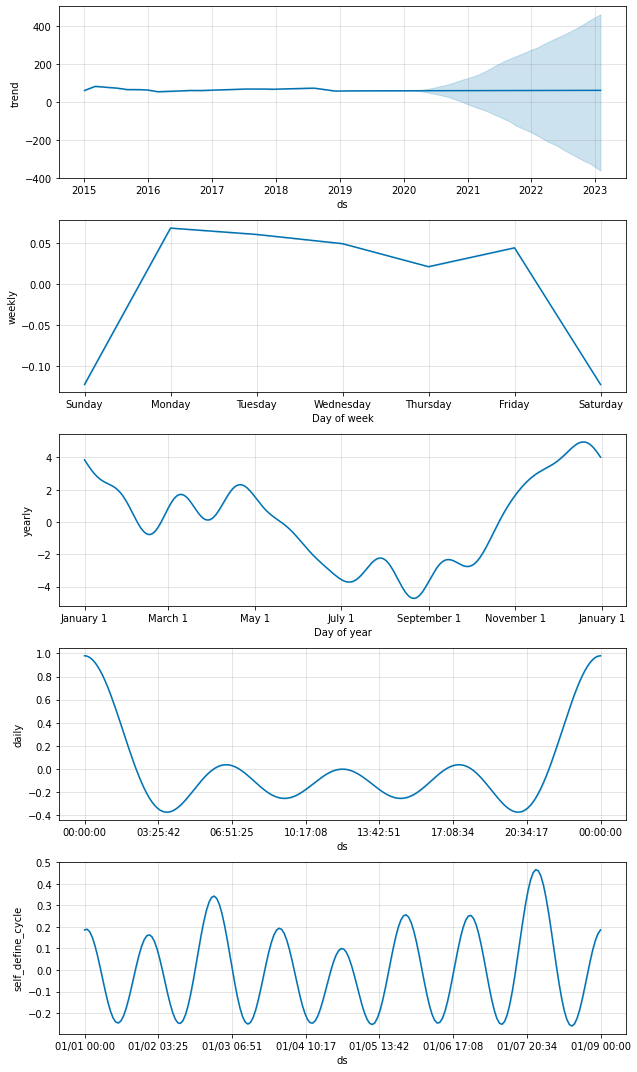

In [19]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [20]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-02 00:00:00 and 2019-02-25 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
748,2020-02-19,50.254943,-103.190130,200.737341,59.174419,2019-02-25
749,2020-02-20,50.362637,-102.608367,200.061301,59.047840,2019-02-25
750,2020-02-21,50.665442,-103.986123,202.043417,58.324554,2019-02-25
751,2020-02-24,50.907997,-104.832989,205.230686,55.548912,2019-02-25
752,2020-02-25,51.089331,-106.384757,205.072086,55.178226,2019-02-25


In [22]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,9.985047,3.159912,2.543510,0.037970,0.032104,0.840000
1,38 days,9.868990,3.141495,2.497056,0.037274,0.031326,0.840000
2,39 days,9.620074,3.101624,2.454997,0.036608,0.029245,0.846667
3,40 days,9.914912,3.148795,2.474016,0.036885,0.028088,0.846667
4,41 days,10.417546,3.227622,2.519340,0.037587,0.027227,0.846667


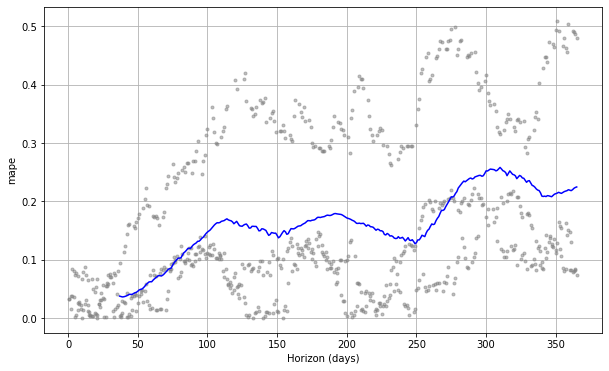

In [23]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [24]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [25]:
m.fit(train_df)

In [26]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as bmw:
    json.dump(model_to_json(m),bmw)

In [27]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1337,2022-09-30,52.986418,-582.798767,623.976583
1338,2022-10-31,58.652723,-611.163711,665.212002
1339,2022-11-30,61.843385,-643.012844,687.393106
1340,2022-12-31,61.836182,-686.584694,711.817141
1341,2023-01-31,57.083552,-737.641586,738.995865


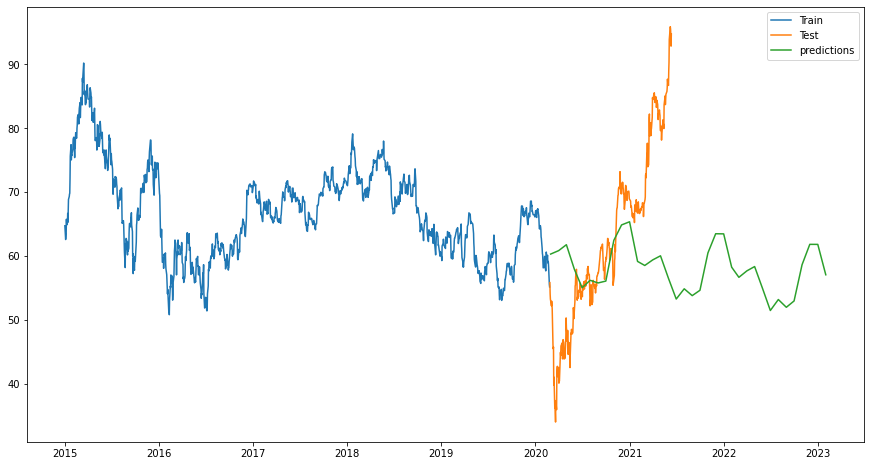

In [28]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [29]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-02 00:00:00 and 2019-02-25 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,20.858648,4.567127,3.623407,0.054012,0.046913,0.373333
1,38 days,21.143550,4.598212,3.641596,0.054216,0.047021,0.386667
2,39 days,21.631798,4.651000,3.664121,0.054415,0.048053,0.400000
3,40 days,25.176850,5.017654,3.868433,0.057389,0.048594,0.400000
4,41 days,29.370334,5.419440,4.106661,0.060916,0.048594,0.393333


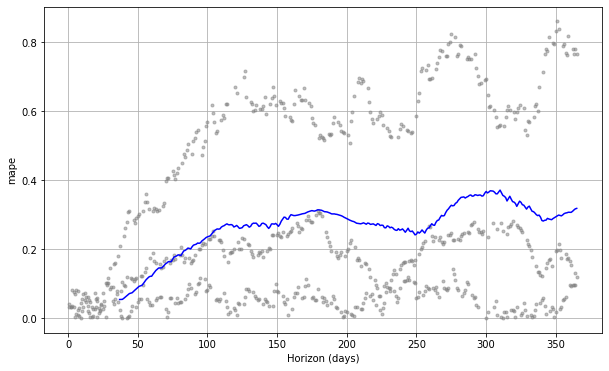

In [31]:
plot_cross_validation_metric(cv_results, metric='mape');